In [20]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [21]:
df = pd.read_csv("../data/BP_data.csv")

In [22]:
df

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,1,10.14,0.02,69,26,1,NaN,1,26118,47568,144.0,3,1,0
1996,1997,1,11.77,1.00,24,45,1,1.0,1,2572,8063,NaN,3,1,1
1997,1998,1,16.91,0.22,18,42,0,NaN,0,14933,24753,NaN,2,1,1
1998,1999,0,11.15,0.72,46,45,1,NaN,1,18157,15275,253.0,3,0,1


In [23]:
df.drop(columns=["Patient_Number", "Pregnancy"], inplace=True)
df["Genetic_Pedigree_Coefficient"] = df["Genetic_Pedigree_Coefficient"].fillna(df["Genetic_Pedigree_Coefficient"].mean())
df["alcohol_consumption_per_day"] = df["alcohol_consumption_per_day"].fillna(df["alcohol_consumption_per_day"].median())

In [24]:
X = df.drop(columns=["Blood_Pressure_Abnormality"])
y = df["Blood_Pressure_Abnormality"]

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [27]:
class Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)  # Binary classification
        )

    def forward(self, x):
        return self.model(x)

model = Classifier(input_dim=X.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
for epoch in range(50):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} / Loss: {loss.item():.4f}")

Epoch 0 / Loss: 0.6097
Epoch 10 / Loss: 0.3674
Epoch 20 / Loss: 0.3251
Epoch 30 / Loss: 0.2367
Epoch 40 / Loss: 0.3352


In [29]:
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_logits, dim=1)

print("\n✅ 정확도:", accuracy_score(y_test_tensor, y_pred))
print("✅ F1 점수:", f1_score(y_test_tensor, y_pred))
print("\n✅ 분류 리포트:\n", classification_report(y_test_tensor, y_pred))
print("✅ 혼동 행렬:\n", confusion_matrix(y_test_tensor, y_pred))


✅ 정확도: 0.87
✅ F1 점수: 0.8617021276595744

✅ 분류 리포트:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88       223
           1       0.81      0.92      0.86       177

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.88      0.87      0.87       400

✅ 혼동 행렬:
 [[186  37]
 [ 15 162]]


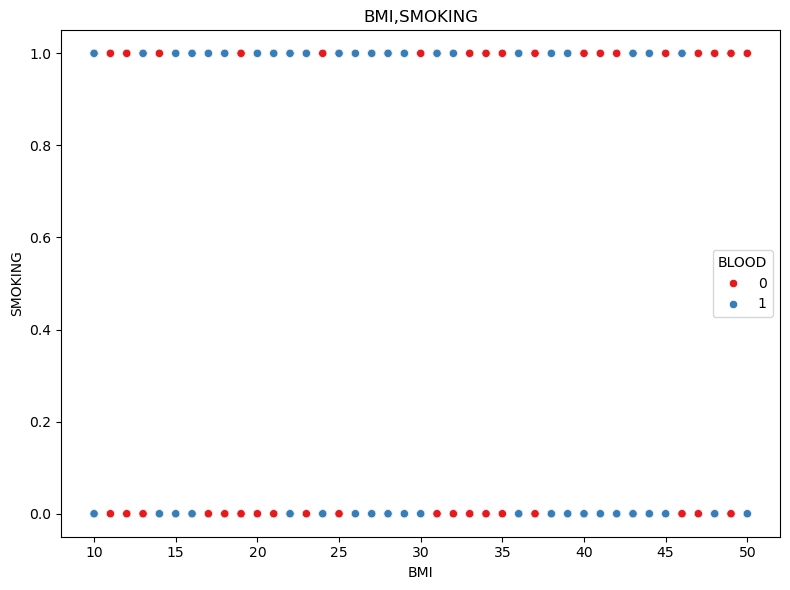

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="BMI",
    y="Smoking",
    hue="Blood_Pressure_Abnormality",
    data=df,
    palette="Set1"
)
plt.title("BMI,SMOKING")
plt.xlabel("BMI")
plt.ylabel("SMOKING")
plt.legend(title="BLOOD")
plt.tight_layout()
plt.show()